<a href="https://colab.research.google.com/github/aserdargun/DSML101/blob/main/tensorflow/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFLow

NLP has the goal of deriving information out of natural language (could be sequences text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq).


## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-db11213a-1d3d-dff9-db7c-9d89ff8eec68)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-10-30 17:03:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-30 17:03:46 (95.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

See the original source here: https://www.kaggle.com/competitions/nlp-getting-started


In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-10-30 17:03:51--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.207, 172.217.204.207, 172.217.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2023-10-30 17:03:51 (58.6 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

Bu I prefer to get visual straight away.

So another way to do this is to use pandas.

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) #create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 1 (real disaster)
Text:
#Laos flooding -10 villages underwater World Vision responding http://t.co/8fvQRizOUX

---

Target: 1 (real disaster)
Text:
UPDATE: 7 of the 9 Mac Pros my company bought in May have had catastrophe failures requiring repair!

---

Target: 0 (not real disaster)
Text:
On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N

---

Target: 1 (real disaster)
Text:
`bbcnews The Ass. of British Insurers says rioting will cost insurers  &amp;#163;163;millions. But police numbers are reduced by blind fat contr

---

Target: 0 (not real disaster)
Text:
Trusting Iran to stop terrorism is like inviting an arsonist to join the fire brigade - Telegraph http://t.co/2Z2HTDjQZD

---



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Use train_test_Split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation split
                                                                            random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll havve to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a characyer) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [14]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be
                                    pad_to_max_tokens=True)

In [16]:
len(train_sentences[0].split())

7

In [17]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 1000 # max number of work
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectırizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized verson:")
text_vectorizer([random_sentence])

Original text:
 Trauma can happen anywhere -- school home etc. -- at any time. Learn the ABC's of trauma and how to parent... Û_ http://t.co/fMj8MXJY8a        

Vectorized verson:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[359,  71,   1,   1, 185, 153,   1,  17, 202,  92, 944,   2,   1,
          6, 359]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 1000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['reported', 'r', 'pray', 'playlist', 'patience']


## Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             embeddings_initializer="uniform",
                             input_length=max_length # how long is each input
                             )
embedding

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 New illustration for the L.A. Times: http://t.co/qYn6KxJSTl #illustration #subway        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01268002, -0.00791764, -0.03237499, ...,  0.02356527,
         -0.01131754,  0.03971888],
        [ 0.01834346, -0.03492544,  0.00646272, ..., -0.03515055,
         -0.00345708,  0.04977122],
        [-0.04705215,  0.0071653 ,  0.02966991, ..., -0.03638879,
          0.04597374, -0.00817844],
        ...,
        [-0.02518454, -0.04637302, -0.00684311, ...,  0.00620383,
          0.02400473,  0.0079272 ],
        [-0.02518454, -0.04637302, -0.00684311, ...,  0.00620383,
          0.02400473,  0.0079272 ],
        [-0.02518454, -0.04637302, -0.00684311, ...,  0.00620383,
          0.02400473,  0.0079272 ]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 1.26800202e-02, -7.91764259e-03, -3.23749930e-02, -6.21017069e-03,
         3.56655456e-02,  3.67607921e-03, -1.07335225e-02,  1.10726357e-02,
        -3.05138230e-02,  1.27686374e-02, -1.93422195e-02, -2.96982657e-02,
         3.35026644e-02, -1.43564455e-02, -1.74529850e-05,  2.53835358e-02,
        -4.95243333e-02, -4.71004099e-03, -2.47934349e-02,  8.99404287e-03,
         1.27834082e-03,  1.68681778e-02, -1.87979229e-02,  4.09347154e-02,
         3.37663628e-02, -4.26921621e-02,  4.66844775e-02,  3.40829827e-02,
         3.64405178e-02,  4.01720442e-02,  3.84610929e-02,  2.74558179e-02,
         7.75309652e-03,  2.64237858e-02,  2.33192779e-02, -1.01218447e-02,
        -2.23866943e-02, -6.97286054e-03, -4.05418053e-02,  1.45009644e-02,
         1.16508491e-02, -1.80049650e-02,  4.84381989e-03, -3.82606164e-02,
         4.25023958e-03,  1.38236210e-03, -2.05456093e-03,  2.88209803e-02,
        -4.75357659e-02,  3.83420698e-0

## Modelling a text dataset (running a series of experiments)

Now we've a got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

## Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got benchmark for future experiments to build upon

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to number.

> ⌨ **Note:** It's common practice to use non-DL algorithms as a baseline because of theri sped and then later using DL to see if you can improve upon them.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [28]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [29]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, tihs will be cumbersome and could easily be fixed with a function.

Let's create one to compare our models's predictions with the truth labes using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the Sklearn documentation:
https://scikit-learn.org/stable/modules/model_evaluation.html

In [30]:
# Function to evaluate accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: A Simple dense model

In [32]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
# x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           128000    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 128129 (500.50 KB)
Trainable params: 12

In [35]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20231030-170403
Epoch 1/5
215/215 [==============================] - 22s 59ms/step - loss: 0.6202 - accuracy: 0.6755 - val_loss: 0.5586 - val_accuracy: 0.7415
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4907 - accuracy: 0.7824 - val_loss: 0.5038 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4378 - accuracy: 0.8076 - val_loss: 0.4905 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4103 - accuracy: 0.8197 - val_loss: 0.4883 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3945 - accuracy: 0.8218 - val_loss: 0.4929 - val_accuracy: 0.7782


In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4929 - accuracy: 0.7782


[0.4929494857788086, 0.778215229511261]

In [38]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 5ms/step


(762, 1)

In [39]:
# look at a single prediction
model_1_pred_probs[0]

array([0.53810406], dtype=float32)

In [40]:
# look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.53810406],
       [0.6791699 ],
       [0.9659565 ],
       [0.11775136],
       [0.12687375],
       [0.92709935],
       [0.85415524],
       [0.8314777 ],
       [0.72949904],
       [0.18718484]], dtype=float32)

In [41]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [42]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.82152230971128,
 'precision': 0.7852962714176315,
 'recall': 0.7782152230971129,
 'f1': 0.7742060338580585}

In [43]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [44]:
# Looks like our baseline is out performing our first deep learning model...
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings

In [45]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(1000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [46]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           128000    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 128129 (500.50 KB)
Trainable params: 12

In [47]:
# Get the weighte matrix of embedding layer
# (these are the numerical representations of each token in our trainign data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(1000, 128)


In [48]:
embed_weights

array([[-0.00499033, -0.03228132, -0.02807313, ...,  0.0262977 ,
         0.04547081, -0.01159838],
       [ 0.03477685, -0.02000723, -0.00994606, ..., -0.01894352,
         0.01323003,  0.03322645],
       [ 0.00611103,  0.02263743, -0.0286259 , ...,  0.07207604,
         0.0614963 , -0.05909916],
       ...,
       [-0.03055179,  0.00149837, -0.03434889, ...,  0.0289878 ,
        -0.03762531, -0.04290157],
       [ 0.02367313,  0.02701482, -0.08464451, ...,  0.08963135,
         0.09112508, -0.08443332],
       [-0.00051441, -0.02298488,  0.05192591, ..., -0.01300782,
        -0.01915901,  0.04676553]], dtype=float32)

Now we've got the embedding matrix our model has learned to represent our tokesn, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projecyor: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings: https://www.tensorflow.org/text/tutorials/word_embeddings

https://jalammar.github.io/illustrated-word2vec/

In [49]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [50]:
# Download files from Colab to upload to projector
#try:
#  from google.colab import files
#  files.download('vectors.tsv')
#  files.download('metadata.tsv')
#except Exception:
#  pass

## Recurrent Neural Network (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> **Resources:** If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modelling lecture : https://www.youtube.com/watch?v=ySEx_Bqxvvo
- Chris Olah's intro to LSTMs :  https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's the unresanable effectiveness of recurrent neural network : https://karpathy.github.io/2015/05/21/rnn-effectiveness/

## Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)


In [51]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

In [52]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           128000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 177473 (693.25 KB)
Trainable params: 177473 (693.25 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [53]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
# Fit the model
model_2.history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231030-170449
Epoch 1/5
215/215 [==============================] - 19s 68ms/step - loss: 0.4011 - accuracy: 0.8269 - val_loss: 0.4800 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3764 - accuracy: 0.8355 - val_loss: 0.5016 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3697 - accuracy: 0.8405 - val_loss: 0.4855 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3572 - accuracy: 0.8472 - val_loss: 0.5331 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3365 - accuracy: 0.8567 - val_loss: 0.5200 - val_accuracy: 0.7690


In [55]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 2s 16ms/step


array([[0.75847995],
       [0.74289876],
       [0.96812874],
       [0.05574173],
       [0.11197995],
       [0.9978841 ],
       [0.9495449 ],
       [0.8888056 ],
       [0.763867  ],
       [0.11846478]], dtype=float32)

In [56]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [57]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.9028871391076,
 'precision': 0.7706028054440214,
 'recall': 0.7690288713910761,
 'f1': 0.7669342344352704}

In [58]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

In [59]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# print(x.shape)
# x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences=True
# print(x.shape)
# x = layers.LSTM(42, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(99)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [60]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20231030-170525
Epoch 1/5
215/215 [==============================] - 17s 60ms/step - loss: 0.3993 - accuracy: 0.8200 - val_loss: 0.5228 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3378 - accuracy: 0.8575 - val_loss: 0.5465 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3185 - accuracy: 0.8664 - val_loss: 0.5268 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2999 - accuracy: 0.8768 - val_loss: 0.5993 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2864 - accuracy: 0.8822 - val_loss: 0.6222 - val_accuracy: 0.7612


In [62]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[0.57072705],
       [0.76807106],
       [0.97467065],
       [0.02608683],
       [0.05043907],
       [0.99461526],
       [0.97061276],
       [0.9343921 ],
       [0.63107926],
       [0.07193072]], dtype=float32)

In [63]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [64]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.11548556430446,
 'precision': 0.7701349420588582,
 'recall': 0.7611548556430446,
 'f1': 0.7557629696442744}

## Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [65]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [66]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           128000    
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 226945 (886.50 KB)
Trainable pa

In [67]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                      "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20231030-170557
Epoch 1/5
215/215 [==============================] - 33s 108ms/step - loss: 0.3533 - accuracy: 0.8540 - val_loss: 0.5624 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.2901 - accuracy: 0.8821 - val_loss: 0.6476 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2667 - accuracy: 0.8914 - val_loss: 0.5877 - val_accuracy: 0.7428
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2512 - accuracy: 0.8997 - val_loss: 0.6854 - val_accuracy: 0.7480
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2336 - accuracy: 0.9075 - val_loss: 0.7625 - val_accuracy: 0.7507


In [69]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[0.9451587 ],
       [0.8210792 ],
       [0.99956137],
       [0.04912171],
       [0.09374121],
       [0.9981754 ],
       [0.9951944 ],
       [0.9962149 ],
       [0.7149839 ],
       [0.11937264]], dtype=float32)

In [70]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [71]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 75.06561679790026,
 'precision': 0.751348225434669,
 'recall': 0.7506561679790026,
 'f1': 0.748668358878424}

In [72]:
model_3_results

{'accuracy': 76.11548556430446,
 'precision': 0.7701349420588582,
 'recall': 0.7611548556430446,
 'f1': 0.7557629696442744}

**Convolution Neural Networks for Text (and other types of sequences)**

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've Conv2D for our image data but now we're goingto use Conv2D

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) typically Conv1D + pooling -> Outputs (class probabilities)
```

## Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)
* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [73]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1, # default
                        activation="relu",
                        padding="same") # default = "valid", the output is smaller than the input shape, "same" means output is same with input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most importan feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [74]:
# embedding_test

In [75]:
# conv_1d_output

In [76]:
# max_pool_output

In [77]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = laters.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           128000    
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [78]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20231030-170734
Epoch 1/5
215/215 [==============================] - 13s 45ms/step - loss: 0.3723 - accuracy: 0.8408 - val_loss: 0.5470 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3375 - accuracy: 0.8589 - val_loss: 0.5687 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3104 - accuracy: 0.8705 - val_loss: 0.5544 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2829 - accuracy: 0.8880 - val_loss: 0.6376 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2504 - accuracy: 0.9040 - val_loss: 0.6464 - val_accuracy: 0.7690


In [79]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.99150825],
       [0.90864915],
       [0.9787692 ],
       [0.04561061],
       [0.36925018],
       [0.9999933 ],
       [0.9386419 ],
       [0.9786574 ],
       [0.586171  ],
       [0.09417422]], dtype=float32)

In [80]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [81]:
# Evaluate model 5 predicitions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.9028871391076,
 'precision': 0.7693974434525301,
 'recall': 0.7690288713910761,
 'f1': 0.7676527036976099}

In [82]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the UE was created here: https://arxiv.org/abs/1803.11175

https://huggingface.co/models


In [83]:
sample_sentence

"There's a flood in my street!"

In [84]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the unicersa sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [85]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157028,  0.0248591 ,  0.02878048, ..., -0.00186124,
         0.02315826, -0.01485021],
       [ 0.03378637, -0.08772667,  0.00856966, ..., -0.01806664,
         0.01027444,  0.00245354]], dtype=float32)>

In [86]:
embed_samples[0].shape

TensorShape([512])

In [87]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [88]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")],
    name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [89]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231030-170836
Epoch 1/5
215/215 [==============================] - 7s 19ms/step - loss: 0.5075 - accuracy: 0.7809 - val_loss: 0.4469 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4138 - accuracy: 0.8151 - val_loss: 0.4371 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4013 - accuracy: 0.8232 - val_loss: 0.4290 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3922 - accuracy: 0.8253 - val_loss: 0.4273 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3858 - accuracy: 0.8291 - val_loss: 0.4228 - val_accuracy: 0.8189


In [90]:
# Make predictions with UE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.16329674],
       [0.81214756],
       [0.990515  ],
       [0.22710435],
       [0.7276461 ],
       [0.7293564 ],
       [0.9837376 ],
       [0.98199826],
       [0.9451448 ],
       [0.09983299]], dtype=float32)

In [91]:
# Convert predicition probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8205632517459724,
 'recall': 0.8188976377952756,
 'f1': 0.8176416157404923}

In [93]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [94]:
len(train_sentences)

6851

In [95]:
len(train_df)

7613

In [96]:
len(train_df_shuffled)

7613

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [97]:
train_sentences[:5], val_sentences[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object),
 array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: get inside stay inside and

In [98]:
## NOTE: Making datasplits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROMN VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1, random_state=42)
# train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

📓 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be weong. If something looks too good to be true (a model trained on 10& of data outperforming the same model trained on 100% of data) trust your gut and ho back through to find where the error may lie.

In [99]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent)

685

In [100]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [101]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model same as a previous model you've created you can use the `tf.keras.models.clone_model()`methos, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model


In [102]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")],
    name="model_7_USE")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [103]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20231030-170901
Epoch 1/5
22/22 [==============================] - 3s 54ms/step - loss: 0.6682 - accuracy: 0.6599 - val_loss: 0.6487 - val_accuracy: 0.6942
Epoch 2/5
22/22 [==============================] - 1s 31ms/step - loss: 0.5957 - accuracy: 0.8000 - val_loss: 0.5904 - val_accuracy: 0.7598
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5197 - accuracy: 0.8204 - val_loss: 0.5361 - val_accuracy: 0.7782
Epoch 4/5
22/22 [==============================] - 1s 31ms/step - loss: 0.4597 - accuracy: 0.8204 - val_loss: 0.5032 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 29ms/step - loss: 0.4171 - accuracy: 0.8307 - val_loss: 0.4936 - val_accuracy: 0.7822


In [104]:
# Make predicitions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.22162952],
       [0.57515776],
       [0.89662725],
       [0.3641606 ],
       [0.53564346],
       [0.66210365],
       [0.8753266 ],
       [0.7817595 ],
       [0.8473773 ],
       [0.1593283 ]], dtype=float32)

In [105]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [106]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 78.21522309711287,
 'precision': 0.7840694582051416,
 'recall': 0.7821522309711286,
 'f1': 0.7801766074787211}

In [107]:
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8205632517459724,
 'recall': 0.8188976377952756,
 'f1': 0.8176416157404923}

## Comparing the performance of each of our models

In [108]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
# all_model_results

In [109]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [110]:
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.778215,0.785296,0.778215,0.774206
2_lstm,0.769029,0.770603,0.769029,0.766934
3_gru,0.761155,0.770135,0.761155,0.755763
4_bidirectional,0.750656,0.751348,0.750656,0.748668
5_conv1d,0.769029,0.769397,0.769029,0.767653
6_tf_hub_use_encoder,0.818898,0.820563,0.818898,0.817642
7_tf_hub_use_encoder_10_percent,0.782152,0.784069,0.782152,0.780177


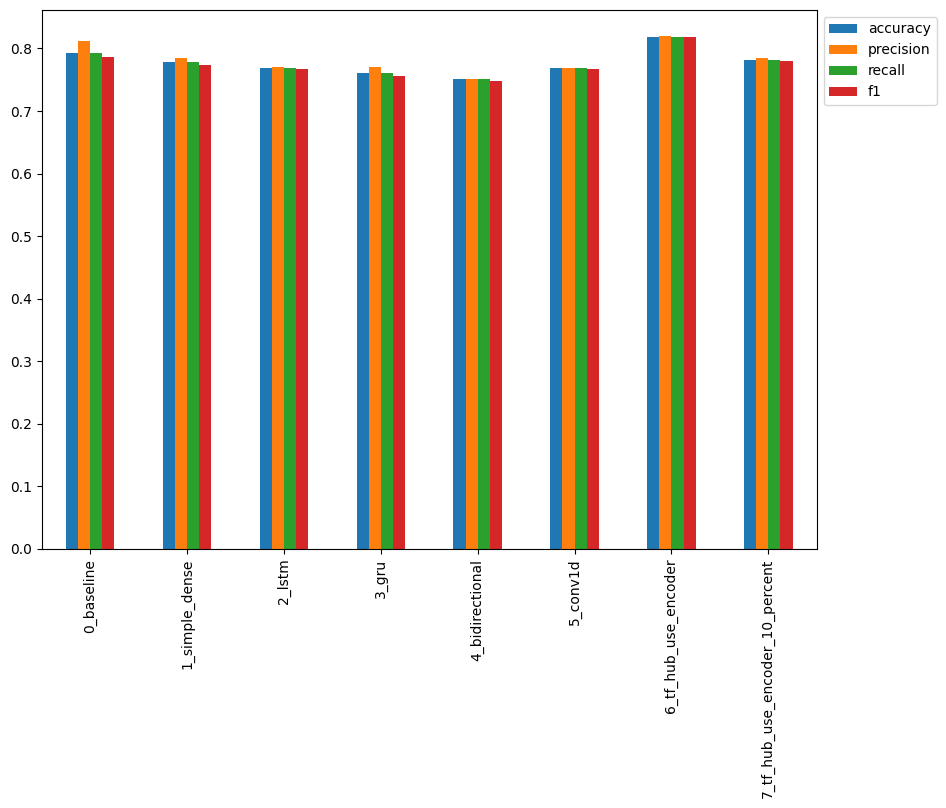

In [111]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

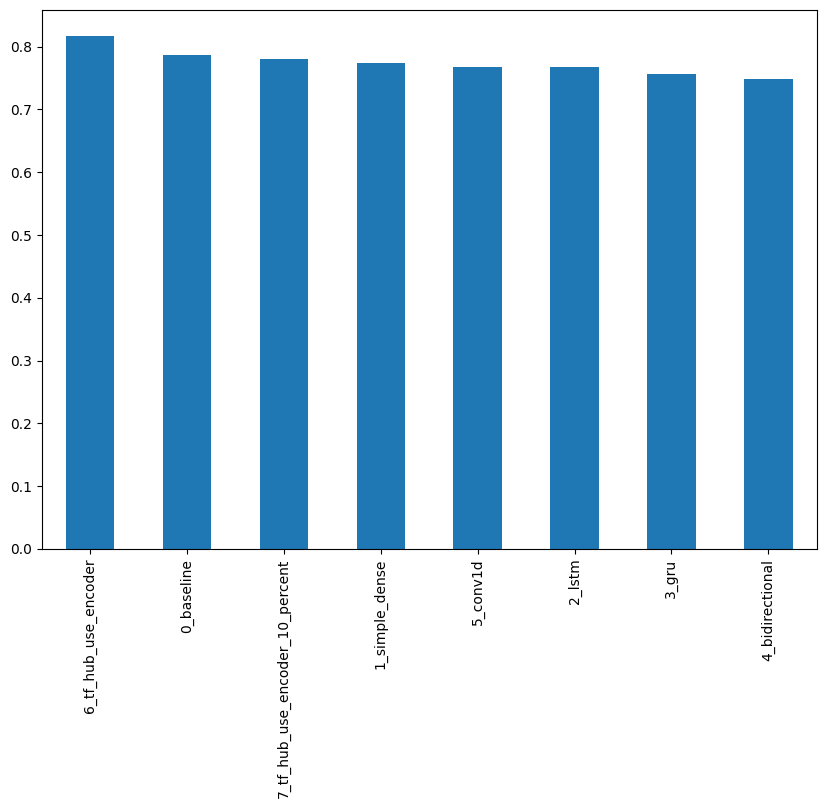

In [112]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Uploading our model training logsto TensorBoard.dev
We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev

In [113]:
# View TensorBoard lohs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
    --name "NLP Modelling Experiments ZTM TF Course Video" \
    --description "Comparing multiple different types of model architectures on The Kaggle Tweets text classification dataset" \
    --one_shot # exit the uploader once uploading is finished

2023-10-30 17:09:10.594488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 17:09:10.594555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 17:09:10.594602: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 17:09:12.340085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of t

Now I've ran the cell above, my modelling experiments are visable on TensorBoard.dev:

> 📓 **Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: https://wandb.ai/site

In [114]:
# See the previous TensorBoard Dev experiments you've run...
!tensorboard dev list

2023-10-30 17:41:47.316046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 17:41:47.316112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 17:41:47.316163: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 17:41:49.145290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

****************************************************************
****************************************************************
****************************************************************

NOTICE - ACTION REQUIRED: TensorBoard.dev

In [115]:
# If you need to delete an experiment from TensorBoard, you can run the following:
# !tensorboard dev delete --experiment_id 9UO8BBQERneoLkBy8o60Sg

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [118]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [119]:
import tensorflow_hub as hub
# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [120]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 23ms/step - loss: 0.4228 - accuracy: 0.8189


[0.4228093922138214, 0.8188976645469666]

In [121]:
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8205632517459724,
 'recall': 0.8188976377952756,
 'f1': 0.8176416157404923}

Now let's save to the `SavedModel` format... (see more on this here:  https://www.tensorflow.org/tutorials/keras/save_and_load)

In [122]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [123]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [124]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 14ms/step - loss: 0.4228 - accuracy: 0.8189


[0.4228093922138214, 0.8188976645469666]

In [125]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (rally close to 1) and vice versa.

In [133]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-10-30 17:50:18--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.207, 172.217.204.207, 172.217.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  31.6MB/s    in 17s     

2023-10-30 17:50:35 (55.0 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variabl

In [134]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 23ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [135]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

24/24 [==============================] - 1s 22ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [139]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction label % probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [140]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [141]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourseles of the target labels...
* 0 = disaster
* 1 = disaster

In [143]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [145]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507583171129227
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.05459701269865036
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

## Making predictions on the test dataset

In [151]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("----\n")

1/1 [==============================] - 0s 49ms/step
Pred: 1, Prob: 0.5957542061805725
Text:
@asgharchohan86 @AdilGhumro 
There are floods in kpk because you guys couldn't build dams in 30 years you ruled.
Even for your own Thar

----

1/1 [==============================] - 0s 43ms/step
Pred: 1, Prob: 0.5471591353416443
Text:
Alabama Home Quarantined Over Possible EbolaåÊCase http://t.co/cGKy5rw9cw

----

1/1 [==============================] - 0s 49ms/step
Pred: 1, Prob: 0.5169217586517334
Text:
Home Inventories Can Help all Homeowners  in Case of Natural Disaster - ABC News http://t.co/RNWvkBkhWU via @ABC

----

1/1 [==============================] - 0s 64ms/step
Pred: 1, Prob: 0.8114635348320007
Text:
Why American censors supressed accounts of suffering in Nagasaki http://t.co/kZbeas50KE http://t.co/YQgpaSX3MG

----

1/1 [==============================] - 0s 71ms/step
Pred: 0, Prob: 0.4403829872608185
Text:
Dorion: Sens looking for consistency from Hoffman #ColoradoAvalanche #Avalanch

## Your challenge... predicting on Tweets from the wild

Go to your favourite Twitter account and copy one of their latest Tweets.

Then pass that Tweet through our trained model.

Is that Tweet a disaster or not disaster (according to the model)? Is the model right or wrong?

## The speed/score tradeoff

In [157]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
    """
    Times how long a model takes to make predictions on samples.
    """
    start_time = time.perf_counter() # get start time
    model.predict(samples) # make predictions
    end_time = time.perf_counter() # get finish time
    total_time = end_time-start_time # clculate how long predictions took to make
    time_per_pred = total_time/len(samples)
    return total_time, time_per_pred

In [158]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                           samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 1s 23ms/step


(0.6778151780008557, 0.0008895212309722515)

In [160]:
# Calculate our baseline model times perpred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.034437557000273955, 4.51936443573149e-05)

In [161]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

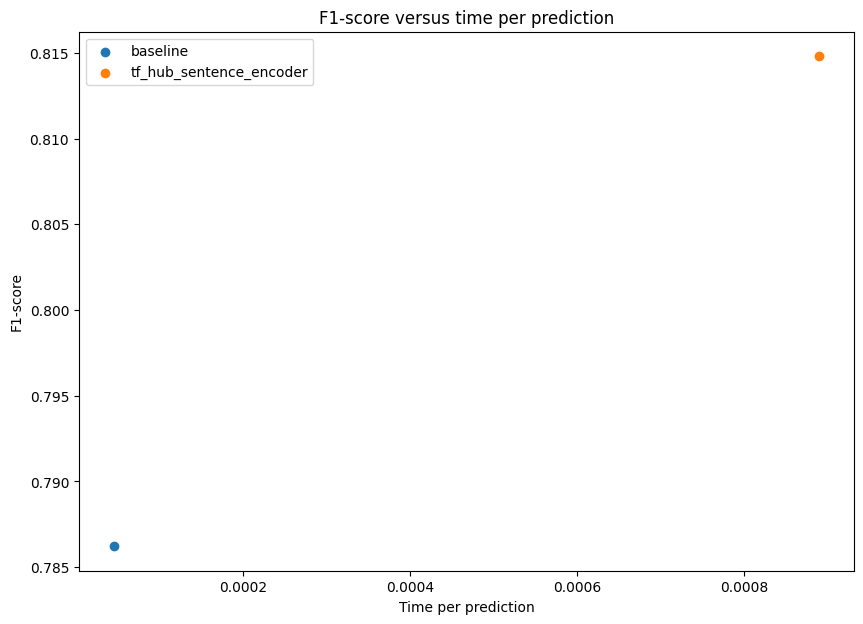

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");